69/69 [==============================] - 0s 356us/step


69/69 [==============================] - 0s 325us/step


69/69 [==============================] - 0s 337us/step


69/69 [==============================] - 0s 345us/step


69/69 [==============================] - 0s 324us/step


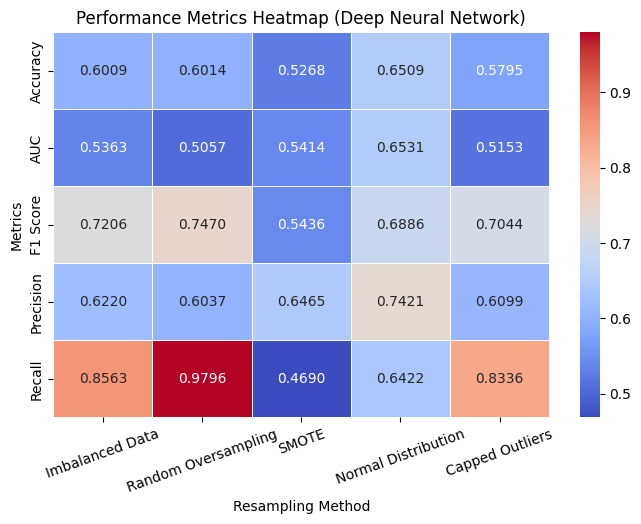

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy import stats

df = pd.read_csv('../Data/Encoded_data.csv')
X = df.drop('Reached', axis=1)
y = df['Reached']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a deep neural network model
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

resampling_methods = ["Imbalanced Data", "Random Oversampling", "SMOTE", "Normal Distribution", "Capped Outliers"]
results = {}

for method in resampling_methods:
    if method == "Imbalanced Data":
        X_resampled = X
        y_resampled = y
    elif method == "Random Oversampling":
        ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X, y)
    elif method == "SMOTE":
        smote = SMOTE(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    elif method == "Normal Distribution":
        X_resampled = X_train.copy()
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)  # Convert to DataFrame
        for col in X_resampled.columns:
            # Check if data is positive
            if (X_resampled[col] > 0).all():
                # Apply Box-Cox transformation with a small constant
                X_resampled[col] = stats.boxcox(X_resampled[col] + 0.0001)[0]
            else:
                # Handle non-positive data (you can choose an appropriate action)
                pass
        y_resampled = y_train

    elif method == "Capped Outliers":
        X_resampled = X.copy()
        for col in X_resampled.columns:
            std_dev = X_resampled[col].std()
            X_resampled[col] = np.where(X_resampled[col] > 3 * std_dev, 3 * std_dev, X_resampled[col])
        y_resampled = y

    # Create and fit the deep neural network model
    model = create_model(X_resampled.shape[1])
    model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, verbose=0)

    # Make predictions on the test set
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

    # Calculate evaluation metrics for Deep Neural Network
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Store the results for Deep Neural Network
    results[method] = {
        "Accuracy": accuracy,
        "AUC": auc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Plot a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title("Performance Metrics Heatmap (Deep Neural Network)")
plt.xlabel("Resampling Method")
plt.ylabel("Metrics")
plt.xticks(rotation = 20)
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import pickle

class BinaryClassifierNN:
    def __init__(self):
        self.model = None

    def create_model(self, layers, activation, optimizer):
        self.model = keras.Sequential()
        for i, nodes in enumerate(layers):
            if i == 0:
                self.model.add(keras.layers.Dense(nodes, input_dim=X_train.shape[1]))
                self.model.add(keras.layers.Activation(activation))
            else:
                self.model.add(keras.layers.Dense(nodes))
                self.model.add(keras.layers.Activation(activation))
        self.model.add(keras.layers.Dense(1, activation='sigmoid'))  # Output layer
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, batch_size, epochs):
        self.model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred = (y_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        return accuracy, f1, roc_auc

    def save_model(self, filename):
        with open('../Pickle_file/ann_mode.pkl', 'wb') as file:
            pickle.dump(self.model, file)

# Generate synthetic data for binary classification
df = pd.read_csv('../Data/No_outliers.csv')
X = df.drop('Reached', axis = 1)
y = df['Reached']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the model
clf = BinaryClassifierNN()
clf.create_model(layers=(64, 32), activation='relu', optimizer='adam')
clf.train(X_train, y_train, batch_size=32, epochs=10)

# Evaluate the model
accuracy, f1, roc_auc = clf.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)
print("Test ROC AUC Score:", roc_auc)

# Save the trained model to a pickle file
clf.save_model('binary_classifier_model.pkl')
